# 0) Setup — imports, data load, basic viz helper

In this cell we:
- Import the I/O, masks, and flat-field APIs we just built.
- Load the demo stack as `(T, Y, X)` using our robust reader.
- Create a simple `show_pair` helper for quick before/after visuals.


In [1]:
# --- 0) setup ---------------------------------------------------------------
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from hybrid.io.readers import read_tiff_stack
from hybrid.utils import show_pair, robust_limits
from hybrid.masks import crop_sides, soft_disk, apply_mask_to_array
from hybrid.flatfield import estimate_flatfield, apply_from_model, apply_flatfield

# demo data
DATA_DIR = Path("data/shorts")
BASENAME = "MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125.tiff"
SRC = (DATA_DIR / BASENAME).as_posix()

# load as float32, no normalization to keep raw-like intensities
stack = read_tiff_stack(
    SRC, method="auto", normalize_mode="none", dtype="float32", verbose=False
)
T, H, W = stack.shape
frame = stack[T//2].copy()

print("Loaded:", stack.shape, stack.dtype)


Loaded: (300, 800, 768) float32


# 1) Baseline flat-field — no mask

We estimate an illumination map from the raw stack (no FOV mask) and apply it.
- `blur_px` controls the smoothness of the illumination field (typ. 40–80 px).
- We use `normalize="mean"` inside the estimator so the flat’s mean ≈ 1.
- For visualization, we apply with `renormalize="robust"` to map percentiles to `[0,1]`.

[GPU-auto] CuPy available → using GPU backend


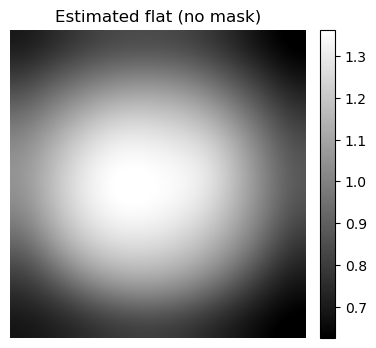

[GPU-auto] CuPy available → using GPU backend


[flatfield apply]: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


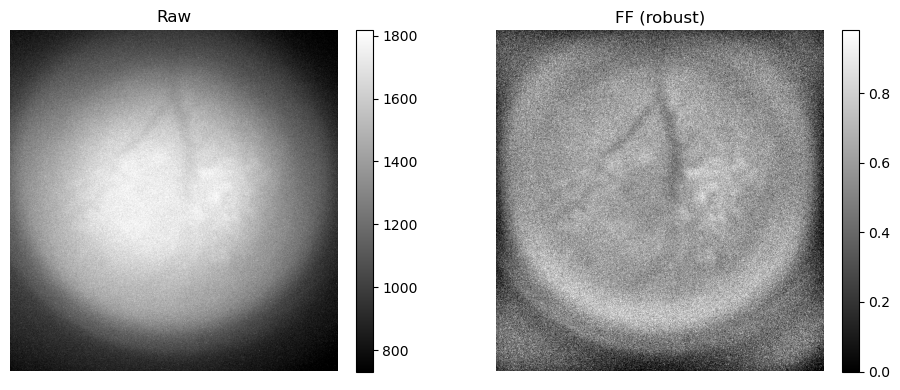

In [13]:
# --- 1) baseline FF (no mask) ----------------------------------------------
model = estimate_flatfield(
    stack,
    blur_px=60.0,          # smooth illumination field (typ. 40–80)
    mask=None,             # no FOV mask in estimator
    erode_px=0,            # no erosion (since no mask)
    floor_pct=1.0,         # clamp flat to low percentile
    normalize="mean",      # normalize flat to mean≈1
    device="auto",         # auto: GPU if available
)
flat = model["flat_norm"]

# visualize the estimated flat with its own limits
vmin, vmax = robust_limits(flat, p=(1,99))
plt.figure(figsize=(4.5,4)); plt.imshow(flat, cmap="gray", vmin=vmin, vmax=vmax)
plt.title("Estimated flat (no mask)"); plt.axis("off"); plt.colorbar(fraction=0.046, pad=0.04); plt.show()

# apply (with robust display stretching just for visualization)
stack_ff = apply_from_model(
    stack, model,
    renormalize="robust", p_low=1.0, p_high=99.0,
    device="auto", progress=True
)

show_pair(frame, stack_ff[T//2],
          titles=("Raw", "FF (robust)"),
          link_scales=False);  # independent scales to avoid “black squares”


# 2) Crop + center soft mask → estimate with mask → apply

We often work inside a circular FOV. Here we (a) crop off a strip, (b) build a centered soft disk mask, (c) estimate flat **with** the mask (ignores the dark background), and (d) apply it with a mild gain cap.

[GPU-auto] CuPy available → using GPU backend
[GPU-auto] CuPy available → using GPU backend


[flatfield apply]: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


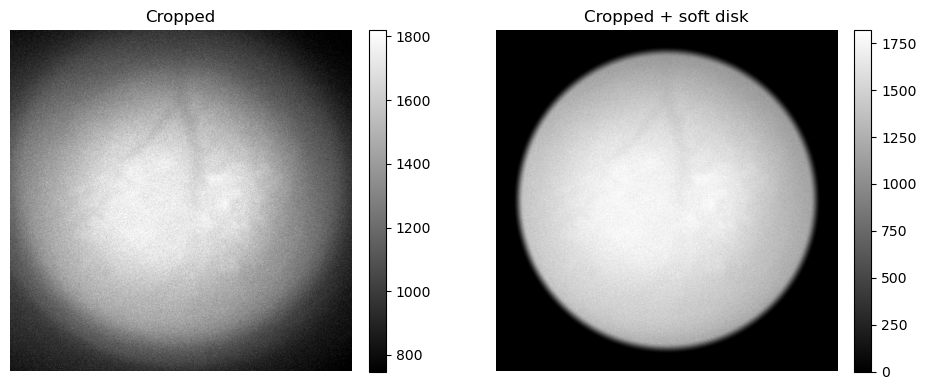

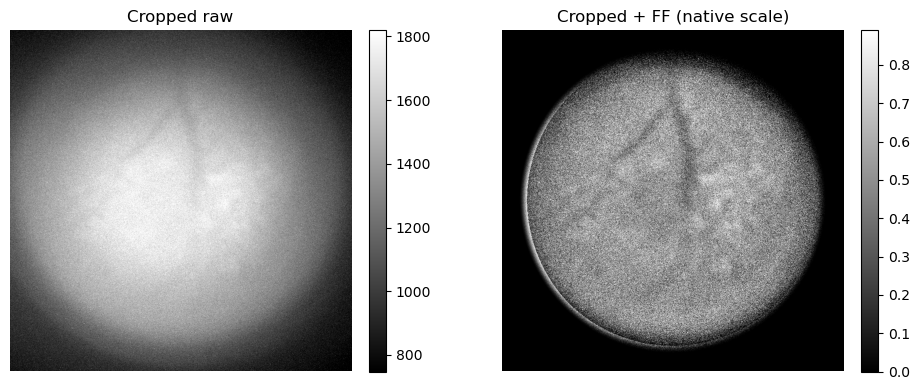

(<Figure size 1000x400 with 4 Axes>,
 array([<Axes: title={'center': 'Cropped raw'}>,
        <Axes: title={'center': 'Cropped + FF (native scale)'}>],
       dtype=object))

In [25]:
# --- 2) Crop + soft disk + mask-aware FF (high local contrast) ---------------

# 2.1 crop
top, bottom, left, right = 0, 32, 0, 0
stack_c = crop_sides(stack, top=top, bottom=bottom, left=left, right=right)
T, Hc, Wc = stack_c.shape
frame_c = stack_c[T//2]

# 2.2 centered soft-disk mask on the cropped view
edge_px = 24
r_frac  = 0.90
cy, cx  = (Hc - 1) / 2.0, (Wc - 1) / 2.0
r       = r_frac * min(Hc, Wc) / 2.0
m_c     = soft_disk(Hc, Wc, cy, cx, r, edge=edge_px)

# 2.3 estimate flat on the cropped stack, aware of the FOV mask
model_c = estimate_flatfield(
    stack_c,
    blur_px=40.0,
    mask=m_c,          # ignore outside FOV when estimating
    erode_px=6,        # eroded core helps not to pull the rim
    floor_pct=5.0,     # safer floor inside FOV
    normalize="mean",
    device="auto",
)
flat_c = model_c["flat_norm"]

# 2.4 apply FF WITHOUT in-function robust rescale and WITHOUT masking,
#     to keep the native dynamic range (more local contrast).
#     We still keep a mild gain cap to avoid over-amplification.
stack_c_ff = apply_from_model(
    stack_c, model_c,
    mask=None,                 # do not mask inside apply()
    gain_cap=1.7,              # optional safety
    renormalize="robust", p_low=30.0, p_high=99.0,        # <-- crucial for contrast
    device="auto", progress=True
)

# 2.5 visualize:
#     A) before vs masked-only,
#     B) raw cropped vs FF result (then we multiply by the mask only for display).
frame_ff_vis = (stack_c_ff[T//2] * m_c).astype(np.float32, copy=False)

show_pair(frame_c, frame_c * m_c, titles=("Cropped", "Cropped + soft disk"))
show_pair(frame_c, frame_ff_vis,
          titles=("Cropped raw", "Cropped + FF (native scale)"),
          link_scales=False)  # independent robust limits per panel

# (Optional) a 2×2 dashboard with independent scaling per tile:
# show_pair_quad(
#     frame_c, frame_c * m_c, frame_c, frame_ff_vis,
#     titles=("Cropped", "Cropped + soft disk", "Cropped raw", "Cropped + FF"),
#     link_scales=False
# )


# 3) Why telling about the mask matters

Compare applying a model estimated **without** the FOV mask (on the cropped data) vs the mask-aware model. Both are applied with the display rescale for comparability.

[GPU-auto] CuPy available → using GPU backend
[GPU-auto] CuPy available → using GPU backend


[flatfield apply]: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


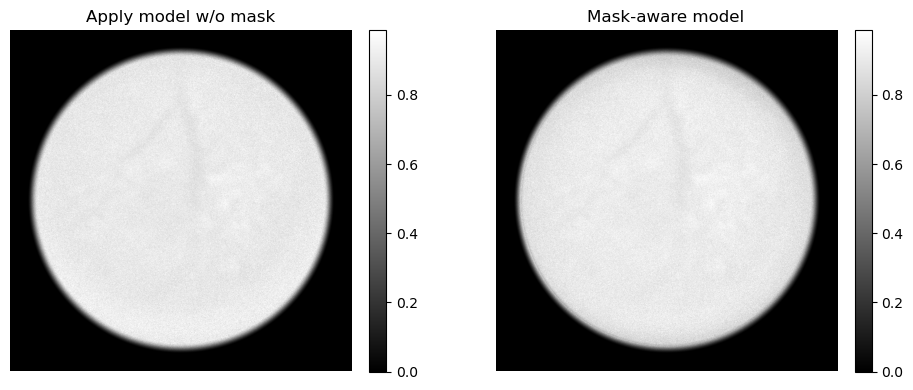

(<Figure size 1000x400 with 4 Axes>,
 array([<Axes: title={'center': 'Apply model w/o mask'}>,
        <Axes: title={'center': 'Mask-aware model'}>], dtype=object))

In [5]:
# --- 3) masked data: estimator w/o mask vs with mask -----------------------
model_nomask_on_c = estimate_flatfield(
    stack_c,
    blur_px=40.0,
    mask=None, erode_px=0, floor_pct=5.0,
    normalize="mean", device="auto",
)
ff_nomask = apply_from_model(
    stack_c, model_nomask_on_c,
    mask=m_c,  # still blank out edges at apply-time
    renormalize="robust", device="auto", progress=True
)

show_pair(ff_nomask[T // 2], stack_c_ff[T // 2],
          titles=("Apply model w/o mask", "Mask-aware model"),
          link_scales=True)


# 4) Gain cap effect (optional QC)

Show the effect of `gain_cap`: unrestricted vs `gain_cap=1.7`.

[GPU-auto] CuPy available → using GPU backend


[flatfield apply]: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.58it/s]


[GPU-auto] CuPy available → using GPU backend


[flatfield apply]: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


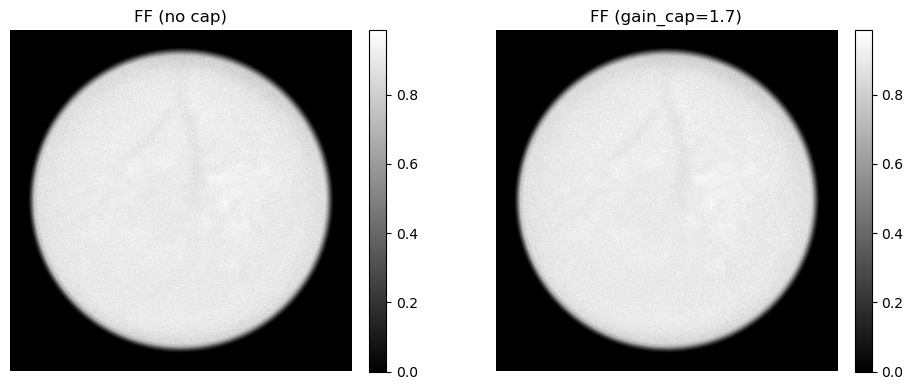

(<Figure size 1000x400 with 4 Axes>,
 array([<Axes: title={'center': 'FF (no cap)'}>,
        <Axes: title={'center': 'FF (gain_cap=1.7)'}>], dtype=object))

In [6]:
# --- 4) gain cap effect ----------------------------------------------------
ff_no_cap = apply_from_model(
    stack_c, model_c,
    mask=m_c, gain_cap=None,
    renormalize="robust", device="auto", progress=True
)
ff_cap = apply_from_model(
    stack_c, model_c,
    mask=m_c, gain_cap=1.7,
    renormalize="robust", device="auto", progress=True
)

show_pair(ff_no_cap[T // 2], ff_cap[T // 2],
          titles=("FF (no cap)", "FF (gain_cap=1.7)"),
          link_scales=True)


# 5) Flat map quick-look (no mask vs mask-aware)

Quick side-by-side of the illumination fields to see how masking affects the estimate.

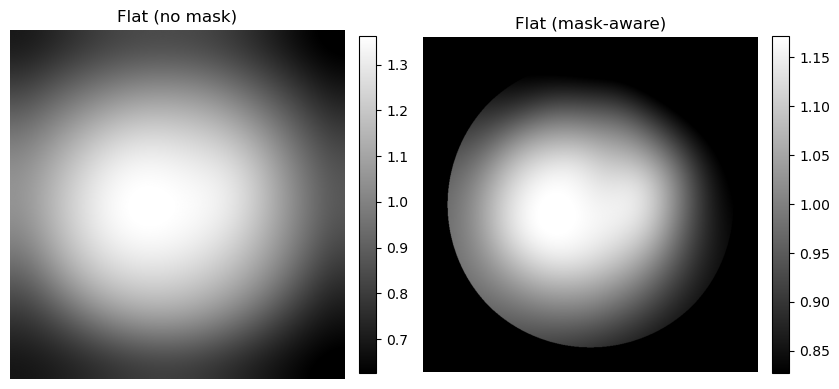

In [7]:
# --- 5) compare flat maps ---------------------------------------------------
v1 = robust_limits(flat,   p=(1, 99))
v2 = robust_limits(flat_c, p=(1, 99))

fig, ax = plt.subplots(1, 2, figsize=(8.5, 4))
im0 = ax[0].imshow(flat,   cmap="gray", vmin=v1[0], vmax=v1[1]); ax[0].set_title("Flat (no mask)");  ax[0].set_axis_off(); fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)
im1 = ax[1].imshow(flat_c, cmap="gray", vmin=v2[0], vmax=v2[1]); ax[1].set_title("Flat (mask-aware)"); ax[1].set_axis_off(); fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()
